<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/PDSH-cover-small.png">
*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

<!--NAVIGATION-->
< [Vectorized String Operations](03.10-Working-With-Strings.ipynb) | [Contents](Index.ipynb) | [High-Performance Pandas: eval() and query()](03.12-Performance-Eval-and-Query.ipynb) >

**NOTE:** This hase been slightly modified. It now uses Quandl to retrieve stock price data.

# Working with Time Series

Pandas was developed in the context of financial modeling, so as you might expect, it contains a fairly extensive set of tools for working with dates, times, and time-indexed data.
Date and time data comes in a few flavors, which we will discuss here:

- *Time stamps* reference particular moments in time (e.g., July 4th, 2015 at 7:00am).
- *Time intervals* and *periods* reference a length of time between a particular beginning and end point; for example, the year 2015. Periods usually reference a special case of time intervals in which each interval is of uniform length and does not overlap (e.g., 24 hour-long periods comprising days).
- *Time deltas* or *durations* reference an exact length of time (e.g., a duration of 22.56 seconds).

In this section, we will introduce how to work with each of these types of date/time data in Pandas.
This short section is by no means a complete guide to the time series tools available in Python or Pandas, but instead is intended as a broad overview of how you as a user should approach working with time series.
We will start with a brief discussion of tools for dealing with dates and times in Python, before moving more specifically to a discussion of the tools provided by Pandas.
After listing some resources that go into more depth, we will review some short examples of working with time series data in Pandas.

## Dates and Times in Python

The Python world has a number of available representations of dates, times, deltas, and timespans.
While the time series tools provided by Pandas tend to be the most useful for data science applications, it is helpful to see their relationship to other packages used in Python.

### Native Python dates and times: ``datetime`` and ``dateutil``

Python's basic objects for working with dates and times reside in the built-in ``datetime`` module.
Along with the third-party ``dateutil`` module, you can use it to quickly perform a host of useful functionalities on dates and times.
For example, you can manually build a date using the ``datetime`` type:

In [1]:
from datetime import datetime
datetime(year=2015, month=7, day=4)

datetime.datetime(2015, 7, 4, 0, 0)

Or, using the ``dateutil`` module, you can parse dates from a variety of string formats:

In [2]:
from dateutil import parser
date = parser.parse("4th of July, 2015")
date

datetime.datetime(2015, 7, 4, 0, 0)

Once you have a ``datetime`` object, you can do things like printing the day of the week:

In [3]:
date.strftime('%A')

'Saturday'

In the final line, we've used one of the standard string format codes for printing dates (``"%A"``), which you can read about in the [strftime section](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior) of Python's [datetime documentation](https://docs.python.org/3/library/datetime.html).
Documentation of other useful date utilities can be found in [dateutil's online documentation](http://labix.org/python-dateutil).
A related package to be aware of is [``pytz``](http://pytz.sourceforge.net/), which contains tools for working with the most migrane-inducing piece of time series data: time zones.

The power of ``datetime`` and ``dateutil`` lie in their flexibility and easy syntax: you can use these objects and their built-in methods to easily perform nearly any operation you might be interested in.
Where they break down is when you wish to work with large arrays of dates and times:
just as lists of Python numerical variables are suboptimal compared to NumPy-style typed numerical arrays, lists of Python datetime objects are suboptimal compared to typed arrays of encoded dates.

### Typed arrays of times: NumPy's ``datetime64``

The weaknesses of Python's datetime format inspired the NumPy team to add a set of native time series data type to NumPy.
The ``datetime64`` dtype encodes dates as 64-bit integers, and thus allows arrays of dates to be represented very compactly.
The ``datetime64`` requires a very specific input format:

In [4]:
import numpy as np
date = np.array('2015-07-04', dtype=np.datetime64)
date

array('2015-07-04', dtype='datetime64[D]')

Once we have this date formatted, however, we can quickly do vectorized operations on it:

In [5]:
date + np.arange(12)

array(['2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07',
       '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11',
       '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15'],
      dtype='datetime64[D]')

Because of the uniform type in NumPy ``datetime64`` arrays, this type of operation can be accomplished much more quickly than if we were working directly with Python's ``datetime`` objects, especially as arrays get large
(we introduced this type of vectorization in [Computation on NumPy Arrays: Universal Functions](02.03-Computation-on-arrays-ufuncs.ipynb)).

One detail of the ``datetime64`` and ``timedelta64`` objects is that they are built on a *fundamental time unit*.
Because the ``datetime64`` object is limited to 64-bit precision, the range of encodable times is $2^{64}$ times this fundamental unit.
In other words, ``datetime64`` imposes a trade-off between *time resolution* and *maximum time span*.

For example, if you want a time resolution of one nanosecond, you only have enough information to encode a range of $2^{64}$ nanoseconds, or just under 600 years.
NumPy will infer the desired unit from the input; for example, here is a day-based datetime:

In [6]:
np.datetime64('2015-07-04')

numpy.datetime64('2015-07-04')

Here is a minute-based datetime:

In [7]:
np.datetime64('2015-07-04 12:00')

numpy.datetime64('2015-07-04T12:00')

Notice that the time zone is automatically set to the local time on the computer executing the code.
You can force any desired fundamental unit using one of many format codes; for example, here we'll force a nanosecond-based time:

In [8]:
np.datetime64('2015-07-04 12:59:59.50', 'ns')

numpy.datetime64('2015-07-04T12:59:59.500000000')

The following table, drawn from the [NumPy datetime64 documentation](http://docs.scipy.org/doc/numpy/reference/arrays.datetime.html), lists the available format codes along with the relative and absolute timespans that they can encode:

|Code    | Meaning     | Time span (relative) | Time span (absolute)   |
|--------|-------------|----------------------|------------------------|
| ``Y``  | Year	       | ± 9.2e18 years       | [9.2e18 BC, 9.2e18 AD] |
| ``M``  | Month       | ± 7.6e17 years       | [7.6e17 BC, 7.6e17 AD] |
| ``W``  | Week	       | ± 1.7e17 years       | [1.7e17 BC, 1.7e17 AD] |
| ``D``  | Day         | ± 2.5e16 years       | [2.5e16 BC, 2.5e16 AD] |
| ``h``  | Hour        | ± 1.0e15 years       | [1.0e15 BC, 1.0e15 AD] |
| ``m``  | Minute      | ± 1.7e13 years       | [1.7e13 BC, 1.7e13 AD] |
| ``s``  | Second      | ± 2.9e12 years       | [ 2.9e9 BC, 2.9e9 AD]  |
| ``ms`` | Millisecond | ± 2.9e9 years        | [ 2.9e6 BC, 2.9e6 AD]  |
| ``us`` | Microsecond | ± 2.9e6 years        | [290301 BC, 294241 AD] |
| ``ns`` | Nanosecond  | ± 292 years          | [ 1678 AD, 2262 AD]    |
| ``ps`` | Picosecond  | ± 106 days           | [ 1969 AD, 1970 AD]    |
| ``fs`` | Femtosecond | ± 2.6 hours          | [ 1969 AD, 1970 AD]    |
| ``as`` | Attosecond  | ± 9.2 seconds        | [ 1969 AD, 1970 AD]    |

For the types of data we see in the real world, a useful default is ``datetime64[ns]``, as it can encode a useful range of modern dates with a suitably fine precision.

Finally, we will note that while the ``datetime64`` data type addresses some of the deficiencies of the built-in Python ``datetime`` type, it lacks many of the convenient methods and functions provided by ``datetime`` and especially ``dateutil``.
More information can be found in [NumPy's datetime64 documentation](http://docs.scipy.org/doc/numpy/reference/arrays.datetime.html).

### Dates and times in pandas: best of both worlds

Pandas builds upon all the tools just discussed to provide a ``Timestamp`` object, which combines the ease-of-use of ``datetime`` and ``dateutil`` with the efficient storage and vectorized interface of ``numpy.datetime64``.
From a group of these ``Timestamp`` objects, Pandas can construct a ``DatetimeIndex`` that can be used to index data in a ``Series`` or ``DataFrame``; we'll see many examples of this below.

For example, we can use Pandas tools to repeat the demonstration from above.
We can parse a flexibly formatted string date, and use format codes to output the day of the week:

In [9]:
import pandas as pd
date = pd.to_datetime("4th of July, 2015")
date

Timestamp('2015-07-04 00:00:00')

In [10]:
date.strftime('%A')

'Saturday'

Additionally, we can do NumPy-style vectorized operations directly on this same object:

In [11]:
date + pd.to_timedelta(np.arange(12), 'D')

DatetimeIndex(['2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07',
               '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11',
               '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15'],
              dtype='datetime64[ns]', freq=None)

In [12]:
pd.to_timedelta(np.arange(12), 'D')

TimedeltaIndex([ '0 days',  '1 days',  '2 days',  '3 days',  '4 days',
                 '5 days',  '6 days',  '7 days',  '8 days',  '9 days',
                '10 days', '11 days'],
               dtype='timedelta64[ns]', freq=None)

In the next section, we will take a closer look at manipulating time series data with the tools provided by Pandas.

## Pandas Time Series: Indexing by Time

Where the Pandas time series tools really become useful is when you begin to *index data by timestamps*.
For example, we can construct a ``Series`` object that has time indexed data:

In [13]:
index = pd.DatetimeIndex(['2014-07-04', '2014-08-04',
                          '2015-07-04', '2015-08-04'])
data = pd.Series([0, 1, 2, 3], index=index)
data

2014-07-04    0
2014-08-04    1
2015-07-04    2
2015-08-04    3
dtype: int64

Now that we have this data in a ``Series``, we can make use of any of the ``Series`` indexing patterns we discussed in previous sections, passing values that can be coerced into dates:

In [14]:
data['2014-07-04':'2015-07-04']

2014-07-04    0
2014-08-04    1
2015-07-04    2
dtype: int64

There are additional special date-only indexing operations, such as passing a year to obtain a slice of all data from that year:

In [15]:
data['2015']

2015-07-04    2
2015-08-04    3
dtype: int64

Later, we will see additional examples of the convenience of dates-as-indices.
But first, a closer look at the available time series data structures.

## Pandas Time Series Data Structures

This section will introduce the fundamental Pandas data structures for working with time series data:

- For *time stamps*, Pandas provides the ``Timestamp`` type. As mentioned before, it is essentially a replacement for Python's native ``datetime``, but is based on the more efficient ``numpy.datetime64`` data type. The associated Index structure is ``DatetimeIndex``.
- For *time Periods*, Pandas provides the ``Period`` type. This encodes a fixed-frequency interval based on ``numpy.datetime64``. The associated index structure is ``PeriodIndex``.
- For *time deltas* or *durations*, Pandas provides the ``Timedelta`` type. ``Timedelta`` is a more efficient replacement for Python's native ``datetime.timedelta`` type, and is based on ``numpy.timedelta64``. The associated index structure is ``TimedeltaIndex``.

The most fundamental of these date/time objects are the ``Timestamp`` and ``DatetimeIndex`` objects.
While these class objects can be invoked directly, it is more common to use the ``pd.to_datetime()`` function, which can parse a wide variety of formats.
Passing a single date to ``pd.to_datetime()`` yields a ``Timestamp``; passing a series of dates by default yields a ``DatetimeIndex``:

In [16]:
dates = pd.to_datetime([datetime(2015, 7, 3), '4th of July, 2015',
                       '2015-Jul-6', '07-07-2015', '20150708'])
dates

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-06', '2015-07-07',
               '2015-07-08'],
              dtype='datetime64[ns]', freq=None)

Any ``DatetimeIndex`` can be converted to a ``PeriodIndex`` with the ``to_period()`` function with the addition of a frequency code; here we'll use ``'D'`` to indicate daily frequency:

In [17]:
dates.to_period('D')

PeriodIndex(['2015-07-03', '2015-07-04', '2015-07-06', '2015-07-07',
             '2015-07-08'],
            dtype='period[D]', freq='D')

A ``TimedeltaIndex`` is created, for example, when a date is subtracted from another:

In [18]:
dates - dates[0]

TimedeltaIndex(['0 days', '1 days', '3 days', '4 days', '5 days'], dtype='timedelta64[ns]', freq=None)

### Regular sequences: ``pd.date_range()``

To make the creation of regular date sequences more convenient, Pandas offers a few functions for this purpose: ``pd.date_range()`` for timestamps, ``pd.period_range()`` for periods, and ``pd.timedelta_range()`` for time deltas.
We've seen that Python's ``range()`` and NumPy's ``np.arange()`` turn a startpoint, endpoint, and optional stepsize into a sequence.
Similarly, ``pd.date_range()`` accepts a start date, an end date, and an optional frequency code to create a regular sequence of dates.
By default, the frequency is one day:

In [19]:
pd.date_range('2015-07-03', '2015-07-10')

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-05', '2015-07-06',
               '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10'],
              dtype='datetime64[ns]', freq='D')

Alternatively, the date range can be specified not with a start and endpoint, but with a startpoint and a number of periods:

In [20]:
pd.date_range('2015-07-03', periods=8)

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-05', '2015-07-06',
               '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10'],
              dtype='datetime64[ns]', freq='D')

The spacing can be modified by altering the ``freq`` argument, which defaults to ``D``.
For example, here we will construct a range of hourly timestamps:

In [21]:
pd.date_range('2015-07-03', periods=8, freq='H')

DatetimeIndex(['2015-07-03 00:00:00', '2015-07-03 01:00:00',
               '2015-07-03 02:00:00', '2015-07-03 03:00:00',
               '2015-07-03 04:00:00', '2015-07-03 05:00:00',
               '2015-07-03 06:00:00', '2015-07-03 07:00:00'],
              dtype='datetime64[ns]', freq='H')

To create regular sequences of ``Period`` or ``Timedelta`` values, the very similar ``pd.period_range()`` and ``pd.timedelta_range()`` functions are useful.
Here are some monthly periods:

In [22]:
pd.period_range('2015-07', periods=8, freq='M')

PeriodIndex(['2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12',
             '2016-01', '2016-02'],
            dtype='period[M]', freq='M')

And a sequence of durations increasing by an hour:

In [23]:
pd.timedelta_range(0, periods=10, freq='H')

TimedeltaIndex(['00:00:00', '01:00:00', '02:00:00', '03:00:00', '04:00:00',
                '05:00:00', '06:00:00', '07:00:00', '08:00:00', '09:00:00'],
               dtype='timedelta64[ns]', freq='H')

All of these require an understanding of Pandas frequency codes, which we'll summarize in the next section.

## Frequencies and Offsets

Fundamental to these Pandas time series tools is the concept of a frequency or date offset.
Just as we saw the ``D`` (day) and ``H`` (hour) codes above, we can use such codes to specify any desired frequency spacing.
The following table summarizes the main codes available:

| Code   | Description         | Code   | Description          |
|--------|---------------------|--------|----------------------|
| ``D``  | Calendar day        | ``B``  | Business day         |
| ``W``  | Weekly              |        |                      |
| ``M``  | Month end           | ``BM`` | Business month end   |
| ``Q``  | Quarter end         | ``BQ`` | Business quarter end |
| ``A``  | Year end            | ``BA`` | Business year end    |
| ``H``  | Hours               | ``BH`` | Business hours       |
| ``T``  | Minutes             |        |                      |
| ``S``  | Seconds             |        |                      |
| ``L``  | Milliseonds         |        |                      |
| ``U``  | Microseconds        |        |                      |
| ``N``  | nanoseconds         |        |                      |

The monthly, quarterly, and annual frequencies are all marked at the end of the specified period.
By adding an ``S`` suffix to any of these, they instead will be marked at the beginning:

| Code    | Description            || Code    | Description            |
|---------|------------------------||---------|------------------------|
| ``MS``  | Month start            ||``BMS``  | Business month start   |
| ``QS``  | Quarter start          ||``BQS``  | Business quarter start |
| ``AS``  | Year start             ||``BAS``  | Business year start    |

Additionally, you can change the month used to mark any quarterly or annual code by adding a three-letter month code as a suffix:

- ``Q-JAN``, ``BQ-FEB``, ``QS-MAR``, ``BQS-APR``, etc.
- ``A-JAN``, ``BA-FEB``, ``AS-MAR``, ``BAS-APR``, etc.

In the same way, the split-point of the weekly frequency can be modified by adding a three-letter weekday code:

- ``W-SUN``, ``W-MON``, ``W-TUE``, ``W-WED``, etc.

On top of this, codes can be combined with numbers to specify other frequencies.
For example, for a frequency of 2 hours 30 minutes, we can combine the hour (``H``) and minute (``T``) codes as follows:

In [24]:
pd.timedelta_range(0, periods=9, freq="2H30T")

TimedeltaIndex(['00:00:00', '02:30:00', '05:00:00', '07:30:00', '10:00:00',
                '12:30:00', '15:00:00', '17:30:00', '20:00:00'],
               dtype='timedelta64[ns]', freq='150T')

All of these short codes refer to specific instances of Pandas time series offsets, which can be found in the ``pd.tseries.offsets`` module.
For example, we can create a business day offset directly as follows:

In [25]:
from pandas.tseries.offsets import BDay
pd.date_range('2015-07-01', periods=5, freq=BDay())

DatetimeIndex(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-06',
               '2015-07-07'],
              dtype='datetime64[ns]', freq='B')

For more discussion of the use of frequencies and offsets, see the ["DateOffset" section](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#dateoffset-objects) of the Pandas documentation.

## Resampling, Shifting, and Windowing

The ability to use dates and times as indices to intuitively organize and access data is an important piece of the Pandas time series tools.
The benefits of indexed data in general (automatic alignment during operations, intuitive data slicing and access, etc.) still apply, and Pandas provides several additional time series-specific operations.

We will take a look at a few of those here, using some stock price data as an example.
Because Pandas was developed largely in a finance context, it includes some very specific tools for financial data.
For example, the accompanying ``pandas-datareader`` package (installable via ``conda install pandas-datareader``), knows how to import financial data from a number of available sources, including Yahoo finance, Google Finance, and others.
Here we will load Google's closing price history:

In [26]:
import quandl

In [55]:
#API_KEY = ''

In [28]:
quandl.ApiConfig.api_key = API_KEY

In [29]:
df = quandl.get_table('WIKI/PRICES', ticker='GOOG').set_index('date')
df.head()

,ticker,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
date,,,,,,,,,,,,,
2014-03-27,GOOG,568.000,568.00,552.92,558.46,13100.0,0.0,1.0,568.000,568.00,552.92,558.46,13100.0
2014-03-28,GOOG,561.200,566.43,558.67,559.99,41100.0,0.0,1.0,561.200,566.43,558.67,559.99,41100.0
2014-03-31,GOOG,566.890,567.00,556.93,556.97,10800.0,0.0,1.0,566.890,567.00,556.93,556.97,10800.0
2014-04-01,GOOG,558.710,568.45,558.71,567.16,7900.0,0.0,1.0,558.710,568.45,558.71,567.16,7900.0
2014-04-02,GOOG,565.106,604.83,562.19,567.00,146700.0,0.0,1.0,565.106,604.83,562.19,567.00,146700.0


In [30]:
df = df.loc['2004':'2016', ['open', 'high', 'low', 'close', 'volume']]
df.rename(str.title, axis='columns', inplace=True)
df.columns.name = None
df.index.name = 'Date'

In [31]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2014-03-27,568.000,568.00,552.92,558.46,13100.0
2014-03-28,561.200,566.43,558.67,559.99,41100.0
2014-03-31,566.890,567.00,556.93,556.97,10800.0
2014-04-01,558.710,568.45,558.71,567.16,7900.0
2014-04-02,565.106,604.83,562.19,567.00,146700.0


In [32]:
goog = df.copy()

In [33]:
# from pandas_datareader import data

# goog = data.DataReader('GOOG', start='2004', end='2016',
#                        data_source='google')
# goog.head()

For simplicity, we'll use just the closing price:

In [34]:
goog = goog['Close']

We can visualize this using the ``plot()`` method, after the normal Matplotlib setup boilerplate (see [Chapter 4](04.00-Introduction-To-Matplotlib.ipynb)):

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

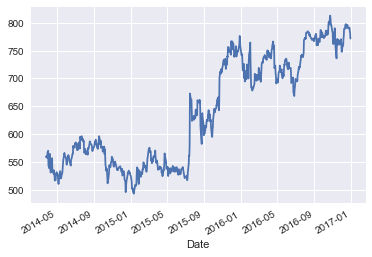

In [36]:
goog.plot();

### Resampling and converting frequencies

One common need for time series data is resampling at a higher or lower frequency.
This can be done using the ``resample()`` method, or the much simpler ``asfreq()`` method.
The primary difference between the two is that ``resample()`` is fundamentally a *data aggregation*, while ``asfreq()`` is fundamentally a *data selection*.

Taking a look at the Google closing price, let's compare what the two return when we down-sample the data.
Here we will resample the data at the end of business year:

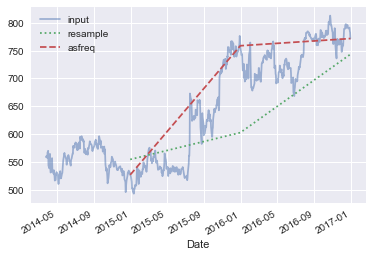

In [37]:
goog.plot(alpha=0.5, style='-')
goog.resample('BA').mean().plot(style=':')
goog.asfreq('BA').plot(style='--');
plt.legend(['input', 'resample', 'asfreq'],
           loc='upper left');

Notice the difference: at each point, ``resample`` reports the *average of the previous year*, while ``asfreq`` reports the *value at the end of the year*.

For up-sampling, ``resample()`` and ``asfreq()`` are largely equivalent, though resample has many more options available.
In this case, the default for both methods is to leave the up-sampled points empty, that is, filled with NA values.
Just as with the ``pd.fillna()`` function discussed previously, ``asfreq()`` accepts a ``method`` argument to specify how values are imputed.
Here, we will resample the business day data at a daily frequency (i.e., including weekends):

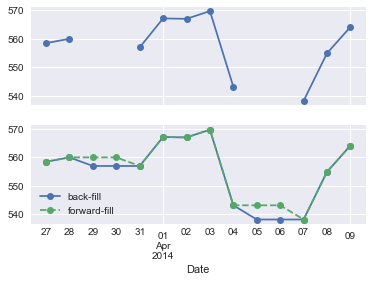

In [38]:
fig, ax = plt.subplots(2, sharex=True)
data = goog.iloc[:10]

data.asfreq('D').plot(ax=ax[0], marker='o')

data.asfreq('D', method='bfill').plot(ax=ax[1], style='-o')
data.asfreq('D', method='ffill').plot(ax=ax[1], style='--o')
ax[1].legend(["back-fill", "forward-fill"]);

The top panel is the default: non-business days are left as NA values and do not appear on the plot.
The bottom panel shows the differences between two strategies for filling the gaps: forward-filling and backward-filling.

### Time-shifts

Another common time series-specific operation is shifting of data in time.
Pandas has two closely related methods for computing this: ``shift()`` and ``tshift()``
In short, the difference between them is that ``shift()`` *shifts the data*, while ``tshift()`` *shifts the index*.
In both cases, the shift is specified in multiples of the frequency.

Here we will both ``shift()`` and ``tshift()`` by 900 days; 

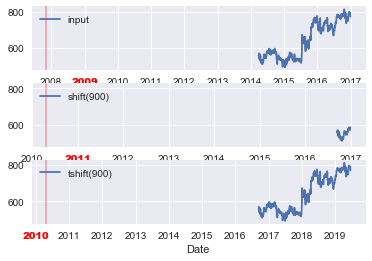

In [39]:
fig, ax = plt.subplots(3, sharey=True)

# apply a frequency to the data
goog = goog.asfreq('D', method='pad')

goog.plot(ax=ax[0])
goog.shift(900).plot(ax=ax[1])
goog.tshift(900).plot(ax=ax[2])

# legends and annotations
local_max = pd.to_datetime('2007-11-05')
offset = pd.Timedelta(900, 'D')

ax[0].legend(['input'], loc=2)
ax[0].get_xticklabels()[2].set(weight='heavy', color='red')
ax[0].axvline(local_max, alpha=0.3, color='red')

ax[1].legend(['shift(900)'], loc=2)
ax[1].get_xticklabels()[2].set(weight='heavy', color='red')
ax[1].axvline(local_max + offset, alpha=0.3, color='red')

ax[2].legend(['tshift(900)'], loc=2)
ax[2].get_xticklabels()[1].set(weight='heavy', color='red')
ax[2].axvline(local_max + offset, alpha=0.3, color='red');

We see here that ``shift(900)`` shifts the *data* by 900 days, pushing some of it off the end of the graph (and leaving NA values at the other end), while ``tshift(900)`` shifts the *index values* by 900 days.

A common context for this type of shift is in computing differences over time. For example, we use shifted values to compute the one-year return on investment for Google stock over the course of the dataset:

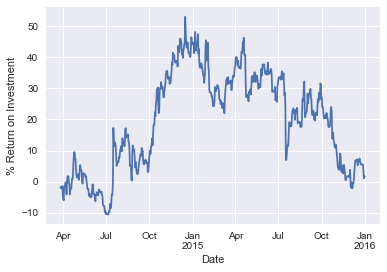

In [40]:
ROI = 100 * (goog.tshift(-365) / goog - 1)
ROI.plot()
plt.ylabel('% Return on Investment');

This helps us to see the overall trend in Google stock: thus far, the most profitable times to invest in Google have been (unsurprisingly, in retrospect) shortly after its IPO, and in the middle of the 2009 recession.

### Rolling windows

Rolling statistics are a third type of time series-specific operation implemented by Pandas.
These can be accomplished via the ``rolling()`` attribute of ``Series`` and ``DataFrame`` objects, which returns a view similar to what we saw with the ``groupby`` operation (see [Aggregation and Grouping](03.08-Aggregation-and-Grouping.ipynb)).
This rolling view makes available a number of aggregation operations by default.

For example, here is the one-year centered rolling mean and standard deviation of the Google stock prices:

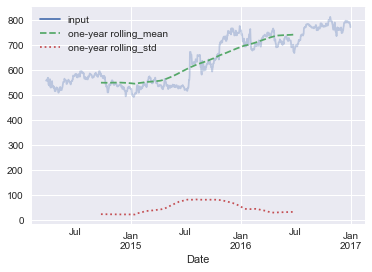

In [41]:
rolling = goog.rolling(365, center=True)

data = pd.DataFrame({'input': goog,
                     'one-year rolling_mean': rolling.mean(),
                     'one-year rolling_std': rolling.std()})
ax = data.plot(style=['-', '--', ':'])
ax.lines[0].set_alpha(0.3)

As with group-by operations, the ``aggregate()`` and ``apply()`` methods can be used for custom rolling computations.

## Where to Learn More

This section has provided only a brief summary of some of the most essential features of time series tools provided by Pandas; for a more complete discussion, you can refer to the ["Time Series/Date" section](http://pandas.pydata.org/pandas-docs/stable/timeseries.html) of the Pandas online documentation.

Another excellent resource is the textbook [Python for Data Analysis](http://shop.oreilly.com/product/0636920023784.do) by Wes McKinney (OReilly, 2012).
Although it is now a few years old, it is an invaluable resource on the use of Pandas.
In particular, this book emphasizes time series tools in the context of business and finance, and focuses much more on particular details of business calendars, time zones, and related topics.

As always, you can also use the IPython help functionality to explore and try further options available to the functions and methods discussed here. I find this often is the best way to learn a new Python tool.

## Example: Visualizing Seattle Bicycle Counts

As a more involved example of working with some time series data, let's take a look at bicycle counts on Seattle's [Fremont Bridge](http://www.openstreetmap.org/#map=17/47.64813/-122.34965).
This data comes from an automated bicycle counter, installed in late 2012, which has inductive sensors on the east and west sidewalks of the bridge.
The hourly bicycle counts can be downloaded from http://data.seattle.gov/; here is the [direct link to the dataset](https://data.seattle.gov/Transportation/Fremont-Bridge-Hourly-Bicycle-Counts-by-Month-Octo/65db-xm6k).

As of summer 2016, the CSV can be downloaded as follows:

In [42]:
# !curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

Once this dataset is downloaded, we can use Pandas to read the CSV output into a ``DataFrame``.
We will specify that we want the Date as an index, and we want these dates to be automatically parsed:

In [43]:
data = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
data.head()

,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk
Date,,
2012-10-03 00:00:00,4.0,9.0
2012-10-03 01:00:00,4.0,6.0
2012-10-03 02:00:00,1.0,1.0
2012-10-03 03:00:00,2.0,3.0
2012-10-03 04:00:00,6.0,1.0


For convenience, we'll further process this dataset by shortening the column names and adding a "Total" column:

In [44]:
data.columns = ['West', 'East']
data['Total'] = data.eval('West + East')

Now let's take a look at the summary statistics for this data:

In [45]:
data.dropna().describe()

,West,East,Total
count,48136.000000,48136.000000,48136.000000
mean,54.569179,55.049422,109.618601
std,72.980790,79.668609,138.591455
min,0.000000,0.000000,0.000000
25%,7.000000,7.000000,15.000000
50%,29.000000,28.000000,59.000000
75%,71.000000,67.000000,143.000000
max,854.000000,717.000000,1165.000000


### Visualizing the data

We can gain some insight into the dataset by visualizing it.
Let's start by plotting the raw data:

In [46]:
%matplotlib inline
import seaborn; seaborn.set()

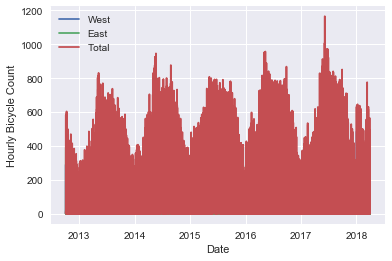

In [47]:
data.plot()
plt.ylabel('Hourly Bicycle Count');

The ~25,000 hourly samples are far too dense for us to make much sense of.
We can gain more insight by resampling the data to a coarser grid.
Let's resample by week:

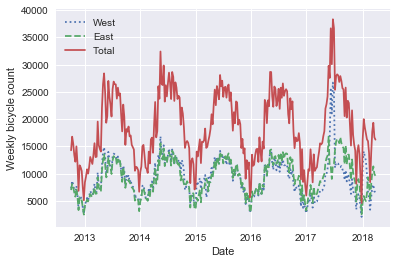

In [48]:
weekly = data.resample('W').sum()
weekly.plot(style=[':', '--', '-'])
plt.ylabel('Weekly bicycle count');

This shows us some interesting seasonal trends: as you might expect, people bicycle more in the summer than in the winter, and even within a particular season the bicycle use varies from week to week (likely dependent on weather; see [In Depth: Linear Regression](05.06-Linear-Regression.ipynb) where we explore this further).

Another way that comes in handy for aggregating the data is to use a rolling mean, utilizing the ``pd.rolling_mean()`` function.
Here we'll do a 30 day rolling mean of our data, making sure to center the window:

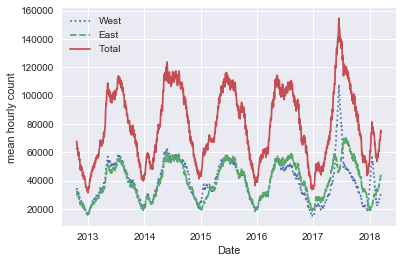

In [49]:
daily = data.resample('D').sum()
daily.rolling(30, center=True).sum().plot(style=[':', '--', '-'])
plt.ylabel('mean hourly count');

The jaggedness of the result is due to the hard cutoff of the window.
We can get a smoother version of a rolling mean using a window function–for example, a Gaussian window.
The following code specifies both the width of the window (we chose 50 days) and the width of the Gaussian within the window (we chose 10 days):

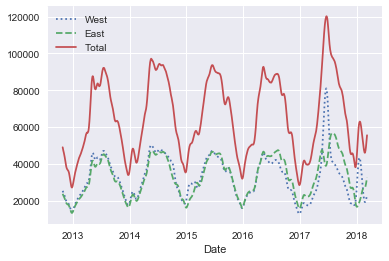

In [50]:
daily.rolling(50, center=True,
              win_type='gaussian').sum(std=10).plot(style=[':', '--', '-']);

### Digging into the data

While these smoothed data views are useful to get an idea of the general trend in the data, they hide much of the interesting structure.
For example, we might want to look at the average traffic as a function of the time of day.
We can do this using the GroupBy functionality discussed in [Aggregation and Grouping](03.08-Aggregation-and-Grouping.ipynb):

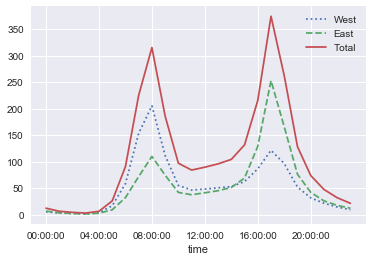

In [51]:
by_time = data.groupby(data.index.time).mean()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks, style=[':', '--', '-']);

The hourly traffic is a strongly bimodal distribution, with peaks around 8:00 in the morning and 5:00 in the evening.
This is likely evidence of a strong component of commuter traffic crossing the bridge.
This is further evidenced by the differences between the western sidewalk (generally used going toward downtown Seattle), which peaks more strongly in the morning, and the eastern sidewalk (generally used going away from downtown Seattle), which peaks more strongly in the evening.

We also might be curious about how things change based on the day of the week. Again, we can do this with a simple groupby:

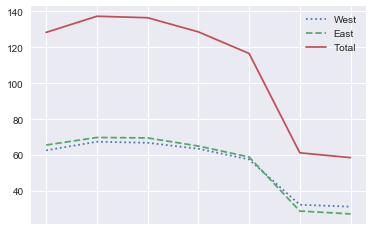

In [52]:
by_weekday = data.groupby(data.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(style=[':', '--', '-']);

This shows a strong distinction between weekday and weekend totals, with around twice as many average riders crossing the bridge on Monday through Friday than on Saturday and Sunday.

With this in mind, let's do a compound GroupBy and look at the hourly trend on weekdays versus weekends.
We'll start by grouping by both a flag marking the weekend, and the time of day:

In [53]:
weekend = np.where(data.index.weekday < 5, 'Weekday', 'Weekend')
by_time = data.groupby([weekend, data.index.time]).mean()

Now we'll use some of the Matplotlib tools described in [Multiple Subplots](04.08-Multiple-Subplots.ipynb) to plot two panels side by side:

C:\Users\Jeremy\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()


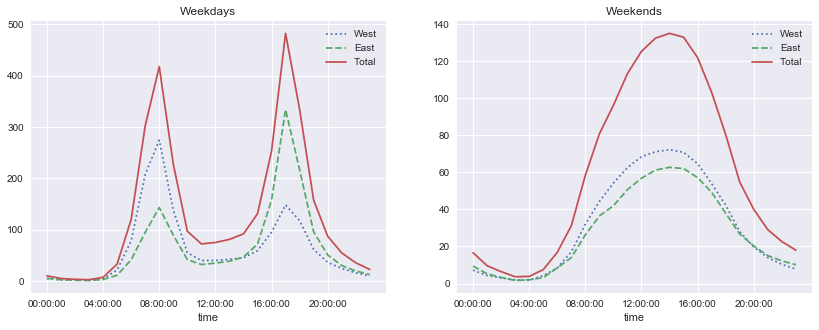

In [54]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_time.ix['Weekday'].plot(ax=ax[0], title='Weekdays',
                           xticks=hourly_ticks, style=[':', '--', '-'])
by_time.ix['Weekend'].plot(ax=ax[1], title='Weekends',
                           xticks=hourly_ticks, style=[':', '--', '-']);

The result is very interesting: we see a bimodal commute pattern during the work week, and a unimodal recreational pattern during the weekends.
It would be interesting to dig through this data in more detail, and examine the effect of weather, temperature, time of year, and other factors on people's commuting patterns; for further discussion, see my blog post ["Is Seattle Really Seeing an Uptick In Cycling?"](https://jakevdp.github.io/blog/2014/06/10/is-seattle-really-seeing-an-uptick-in-cycling/), which uses a subset of this data.
We will also revisit this dataset in the context of modeling in [In Depth: Linear Regression](05.06-Linear-Regression.ipynb).

<!--NAVIGATION-->
< [Vectorized String Operations](03.10-Working-With-Strings.ipynb) | [Contents](Index.ipynb) | [High-Performance Pandas: eval() and query()](03.12-Performance-Eval-and-Query.ipynb) >